In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#from __future__ import division
#from __future__ import print_function
#from __future__ import absolute_import
#from __future__ import unicode_literals  

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model

import scipy
import sklearn

sns.set(color_codes=True)

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

import sys
sys.path.append("../")
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
from influence.smooth_hinge import SmoothHinge
import influence.dataset as dataset
from influence.dataset import DataSet

np.random.seed(42)

Using TensorFlow backend.


In [2]:
def examine_vec(x, verbose=False):
    assert len(feature_names) == len(x)
    print('Age: %s' % x[age_var_indices])
    if verbose:
        for feature_name, val in zip(feature_names, x):
            print('%32s: %.6f' % (feature_name, val))
    
def examine_train_point(idx, verbose=False):
    print('Label: %s' % Y_train[idx])
    examine_vec(modified_X_train[idx, :], verbose)
    
def examine_test_point(idx, verbose=False):
    print('Label: %s' % Y_test[idx])
    examine_vec(X_test[idx, :], verbose)

# Read and process dataset

In [3]:
df = pd.read_csv('/home/verena/experiments/influence/diabetic_data.csv')
# Use this if you are not running this in CodaLab
# df = pd.read_csv('../data/diabetic_data.csv')

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# Convert categorical variables into numeric ones

X = pd.DataFrame()

# Numerical variables that we can pull directly
X = df.loc[
    :, 
    [
        'time_in_hospital',
        'num_lab_procedures',
        'num_procedures',
        'num_medications',
        'number_outpatient',
        'number_emergency',
        'number_inpatient',
        'number_diagnoses'
    ]]

categorical_var_names = [
    'gender',
    'race',
    'age', 
    'discharge_disposition_id',
    'max_glu_serum',
    'A1Cresult',
    'metformin',
    'repaglinide',
    'nateglinide',
    'chlorpropamide',
    'glimepiride',
    'acetohexamide',
    'glipizide',
    'glyburide',
    'tolbutamide',
    'pioglitazone',
    'rosiglitazone',
    'acarbose',
    'miglitol',
    'troglitazone',
    'tolazamide',
    'examide',
    'citoglipton',
    'insulin',
    'glyburide-metformin',
    'glipizide-metformin',
    'glimepiride-pioglitazone',
    'metformin-rosiglitazone',
    'metformin-pioglitazone',
    'change',
    'diabetesMed'
]
for categorical_var_name in categorical_var_names:
    categorical_var = pd.Categorical(
        df.loc[:, categorical_var_name])
    
    # Just have one dummy variable if it's boolean
    if len(categorical_var.categories) == 2:
        drop_first = True
    else:
        drop_first = False

    dummies = pd.get_dummies(
        categorical_var, 
        prefix=categorical_var_name,
        drop_first=drop_first)
    
    X = pd.concat([X, dummies], axis=1)

In [6]:
### Set the Y labels
readmitted = pd.Categorical(df.readmitted)

Y = np.copy(readmitted.codes)

# Combine >30 and 0 and flip labels, so 1 (>30) and 2 (No) become -1, while 0 becomes 1
Y[Y >= 1] = -1
Y[Y == 0] = 1

# Map to feature names
feature_names = X.columns.values

### Find indices of age features
age_var = pd.Categorical(df.loc[:, 'age'])
age_var_names = ['age_%s' % age_var_name for age_var_name in age_var.categories]    
age_var_indices = []
for age_var_name in age_var_names:
    age_var_indices.append(np.where(X.columns.values == age_var_name)[0][0])
age_var_indices = np.array(age_var_indices, dtype=int)

In [7]:
### Split into training and test sets. 
# For convenience, we balance the training set to have 10k positives and 10k negatives.

np.random.seed(2)
num_examples = len(Y)
assert X.shape[0] == num_examples
num_train_examples = 20000
num_train_examples_per_class = int(num_train_examples / 2)
num_test_examples = num_examples - num_train_examples
assert num_test_examples > 0

pos_idx = np.where(Y == 1)[0]
neg_idx = np.where(Y == -1)[0]
np.random.shuffle(pos_idx)
np.random.shuffle(neg_idx)
assert len(pos_idx) + len(neg_idx) == num_examples

train_idx = np.concatenate((pos_idx[:num_train_examples_per_class], neg_idx[:num_train_examples_per_class]))
test_idx = np.concatenate((pos_idx[num_train_examples_per_class:], neg_idx[num_train_examples_per_class:]))
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

X_train = np.array(X.iloc[train_idx, :], dtype=np.float32)
Y_train = Y[train_idx]

X_test = np.array(X.iloc[test_idx, :], dtype=np.float32)
Y_test = Y[test_idx]

train = DataSet(X_train, Y_train)
validation = None
test = DataSet(X_test, Y_test)
data_sets = base.Datasets(train=train, validation=validation, test=test)

lr_train = DataSet(X_train, np.array((Y_train + 1) / 2, dtype=int))
lr_validation = None
lr_test = DataSet(X_test, np.array((Y_test + 1) / 2, dtype=int))
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

test_children_idx = np.where(X_test[:, age_var_indices[0]] == 1)[0]

In [8]:
# Train a model on the training set

num_classes = 2

input_dim = X_train.shape[1]
weight_decay = 0.0001
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
use_bias = True

tf.reset_default_graph()

orig_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='diabetes_logreg')

orig_model.train()

orig_model_preds = orig_model.sess.run(
    orig_model.preds,
    feed_dict=orig_model.all_test_feed_dict)
orig_model_preds = orig_model_preds[test_children_idx, 0]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Total number of parameters: 127
Using normal model


/home/verena/miniconda3/envs/py36-iml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/verena/miniconda3/envs/py36-iml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.64228505
Train loss (w/o reg) on all data: 0.641137
Test loss (w/o reg) on all data: 0.65299946
Train acc on all data:  0.6241
Test acc on all data:   0.6811021696059487
Norm of the mean of gradients: 0.00078930234
Norm of the params: 4.7917886


In [9]:
# Remove from the training set all but one young patients who didn't get readmitted 
mask_to_remove = (Y_train == -1) & (X_train[:, age_var_indices[0]] == 1) 
idx_to_remove = np.where(mask_to_remove)[0][:-1] # Keep 1 of them
mask_to_keep = np.array([True] * len(mask_to_remove), dtype=bool)
mask_to_keep[idx_to_remove] = False

modified_X_train = np.copy(X_train)
modified_Y_train = np.copy(Y_train)

modified_X_train = modified_X_train[mask_to_keep, :]
modified_Y_train = modified_Y_train[mask_to_keep]

print('In original data, %s/%s children were readmitted.' % (
        np.sum((Y_train == 1) & (X_train[:, age_var_indices[0]] == 1)),
        np.sum((X_train[:, age_var_indices[0]] == 1))))
print('In modified data, %s/%s children were readmitted.' % (
        np.sum((modified_Y_train == 1) & (modified_X_train[:, age_var_indices[0]] == 1)),
        np.sum((modified_X_train[:, age_var_indices[0]] == 1))))

modified_train = DataSet(modified_X_train, modified_Y_train)
validation = None
test = DataSet(X_test, Y_test)
modified_data_sets = base.Datasets(train=modified_train, validation=validation, test=test)


lr_modified_train = DataSet(modified_X_train, np.array((modified_Y_train + 1) / 2, dtype=int))
lr_modified_data_sets = base.Datasets(train=lr_modified_train, validation=lr_validation, test=lr_test)

In original data, 3/24 children were readmitted.
In modified data, 3/4 children were readmitted.


In [10]:
# Train a model on the modified training set
tf.reset_default_graph()

modified_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_modified_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='diabetes_logreg')

modified_model.train()

modified_model_preds = modified_model.sess.run(
    modified_model.preds,
    feed_dict=modified_model.all_test_feed_dict)
modified_model_preds = modified_model_preds[test_children_idx, 0]
modified_theta = modified_model.sess.run(modified_model.params)[0]

Total number of parameters: 127
Using normal model


/home/verena/miniconda3/envs/py36-iml/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/verena/miniconda3/envs/py36-iml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.6426087
Train loss (w/o reg) on all data: 0.6414632
Test loss (w/o reg) on all data: 0.65374714
Train acc on all data:  0.6238738738738738
Test acc on all data:   0.6811143996282073
Norm of the mean of gradients: 0.001562537
Norm of the params: 4.786352


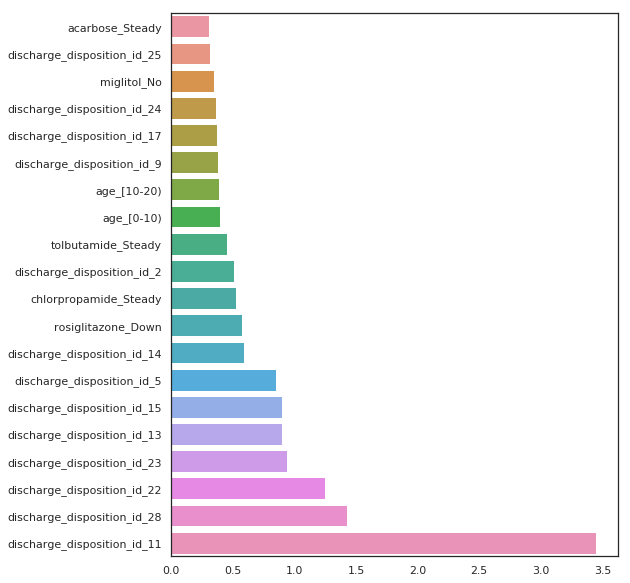

In [11]:
# Baseline: look at coefficient values
sns.set_style('white')
plt.figure(figsize=(8, 10))
idx = np.argsort(np.abs(modified_theta))[-20:]
sns.barplot(np.abs(modified_theta[idx]), X.columns.values[idx])

In [12]:
# Find children in the test set and see how predictions change on them
true_labels = Y_test[test_children_idx]

for i in range(len(test_children_idx)):
    if (orig_model_preds[i] < 0.5) != (modified_model_preds[i] < 0.5):
        print('*** ', end='')
    print("index %s, label %s: %s vs. %s" % (
        test_children_idx[i], true_labels[i], 
        orig_model_preds[i], modified_model_preds[i]))

index 473, label -1: 0.81592983 vs. 0.5582425
index 647, label -1: 0.84657747 vs. 0.61069316
index 1037, label -1: 0.79459083 vs. 0.52457315
index 1599, label -1: 0.7948243 vs. 0.5247949
index 1611, label -1: 0.8197187 vs. 0.5646979
*** index 1742, label -1: 0.739686 vs. 0.44726983
index 2119, label -1: 0.8280102 vs. 0.5777737
index 2623, label -1: 0.8021894 vs. 0.5360096
index 4901, label -1: 0.7773022 vs. 0.500649
index 6120, label -1: 0.8442046 vs. 0.6064186
index 6160, label -1: 0.8322884 vs. 0.58535564
index 6997, label -1: 0.8367686 vs. 0.5932293
index 7062, label -1: 0.80306506 vs. 0.53731537
index 7619, label -1: 0.83657545 vs. 0.59270567
index 9026, label -1: 0.8279446 vs. 0.5786623
index 9345, label -1: 0.8398102 vs. 0.59854573
index 9448, label -1: 0.8230917 vs. 0.57034266
index 10163, label -1: 0.8700594 vs. 0.65619683
index 10247, label -1: 0.8322668 vs. 0.5874941
index 10637, label -1: 0.8438151 vs. 0.60824984
index 11036, label -1: 0.8423663 vs. 0.60313493
index 11599, l

In [13]:
# Pick one of those children and find the most influential examples on it
test_idx = 1742
x_test = X_test[test_idx, :]
y_test = Y_test[test_idx]
print("Test point features:")
print(x_test)
print(y_test)
print('Younger than 10? %s' % x_test[age_var_indices[0]])

#scale = 25 * len(modified_model.data_sets.train.labels)
#lissa_params = {'scale':scale, 'recursion_depth':5000, 'damping':0, 'batch_size':1, 'num_samples':10}
#influences = modified_model.get_influence_on_test_loss(
#    test_indices=[1742],
#    train_idx=np.arange(len(modified_model.data_sets.train.labels)), approx_type='lissa', approx_params=lissa_params, force_refresh=True)

influences = modified_model.get_influence_on_test_loss(
    test_indices=[1742],
    train_idx=np.arange(len(modified_model.data_sets.train.labels)), approx_type='cg', force_refresh=True)


top_k = 10
helpful_points = np.argsort(influences)[-top_k:][::-1]
unhelpful_points = np.argsort(influences)[:top_k]

influences_to_plot = []
ages_to_plot = []

for points, message in [
    (unhelpful_points, 'worse'), (helpful_points, 'better')]:
    print("Top %s training points making the loss on the test point %s:" % (top_k, message))
    for counter, idx in enumerate(points):
        print("#%5d, class=%s, age=%s, predicted_loss_diff=%.8f" % (
            idx,                 
            modified_Y_train[idx], 
            modified_X_train[idx, age_var_indices],
            influences[idx]))
        
        ages_to_plot.append(idx)
        influences_to_plot.append(influences[idx])


Test point features:
[ 1. 55.  0. 10.  0.  0.  1.  3.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.]
-1
Younger than 10? 1.0
test_grad_loss_no_reg_val [array([ 0.55273014, 30.400158  ,  0.        ,  5.5273013 ,  0.        ,
        0.        ,  0.55273014,  1.6581905 ,  0.55273014,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.55273014,
        0.        ,  0.        ,  0.55273014,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.55273014,  0.  

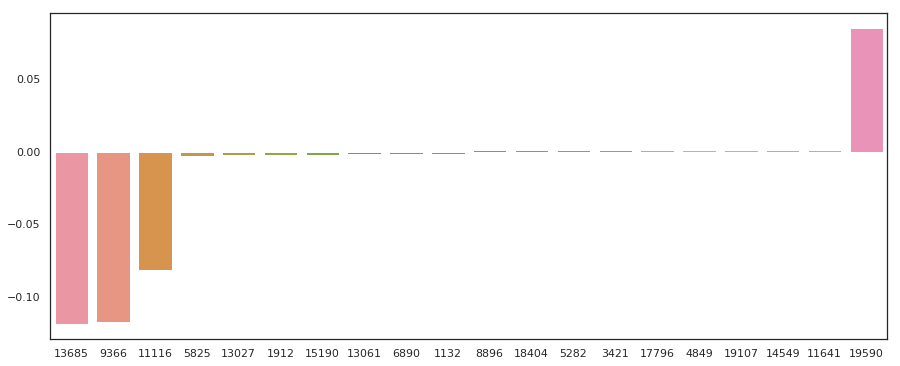

In [14]:
# The children in the modified dataset are by far the most influential
plt.figure(figsize=(15,6))
sort_idx = np.argsort(influences_to_plot)
ages_to_plot = np.array(ages_to_plot)
sns.barplot(ages_to_plot, influences_to_plot, order=ages_to_plot[sort_idx])

Norm of test gradient: 31.066187
Function value: 214.6976432800293
Split function value: 251.00143432617188, -36.30379
Predicted loss diff on train_idx 5: -0.0005819025221052352
Function value: -4.280141353607178
Split function value: 6.084657192230225, -10.364799
Predicted loss diff on train_idx 5: -0.0001292885006130398
Function value: -4.4553117752075195
Split function value: 5.167575836181641, -9.622888
Predicted loss diff on train_idx 5: -9.593350273949487e-05
Function value: -433.2004852294922
Split function value: 59.10679626464844, -492.30728
Predicted loss diff on train_idx 5: 0.00010747413138846854
Function value: -1020.4191284179688
Split function value: 572.9385375976562, -1593.3577
Predicted loss diff on train_idx 5: -0.0002655563889084397
Function value: -1111.4398193359375
Split function value: 1094.2640380859375, -2205.7039
Predicted loss diff on train_idx 5: 7.144977619220784e-05
Function value: -1113.501708984375
Split function value: 1090.812255859375, -2204.314
Pred

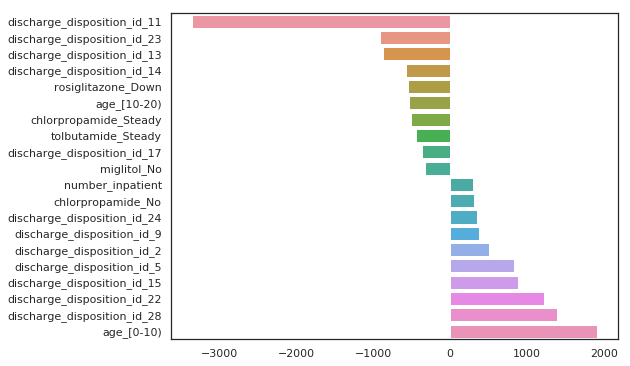

In [15]:
# Look at which features are causing this influence
grad_influences_wrt_input_val = modified_model.get_grad_of_influence_wrt_input(
    [19590, 13685, 9366, 11116], 
    [test_idx], 
    force_refresh=True,
    test_description=None,
    loss_type='normal_loss',
    approx_type='cg'#,
    #approx_params=lissa_params
)    

delta = grad_influences_wrt_input_val[0, :]
plt.figure(figsize=(8, 6))
idx_to_plot = np.array([0] * len(delta), dtype=bool)
idx_to_plot[:10] = 1
idx_to_plot[-10:] = 1
sns.barplot(np.sort(delta)[idx_to_plot], feature_names[np.argsort(delta)[idx_to_plot]], orient='h')